# Apature photometry with_Annulus Background

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, astropy, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name==version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [5]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, photutils, ccdproc, imexam, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        #print(f"**** module {pkg} is not installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module photutils is installed
**** module ccdproc is installed
**** module imexam is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-05-01 23:48:42 (KST = GMT+0900) 
0 Python     3.8.16 64bit [GCC 11.2.0]
1 IPython    8.8.0
2 OS         Linux 5.15.0 71 generic x86_64 with glibc2.17
3 numpy      1.22.0
4 pandas     1.5.2
5 matplotlib 3.2.0
6 scipy      1.8.1
7 astropy    5.2.1
8 photutils  1.6.0
9 ccdproc    2.4.0
10 imexam     0.9.1
11 version_information 1.0.4


### import modules

In [3]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clip, sigma_clipped_stats

from astropy.nddata import Cutout2D

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.centroids import centroid_com
from photutils.aperture import aperture_photometry as apphot
from photutils.aperture import ApertureStats as apstats

import warnings

from ccdproc import CCDData, ccd_process

from astropy.time import Time
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
import ysvisutilpy as yvu

import _Python_utilities
import _astro_utilities
import _tool_visualization as vis

plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
#%%
#####################################################################
# Observed location
LOCATION = dict(lon = 127.0, lat = 37.3, elevation = 130)

# It is used as a rough estimate, so no need to be accurate:
#PIX2ARCSEC = 0.98 * u.arcsec

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit = u.deg, frame = 'icrs')

# Initial guess of FWHM in pixel
FWHM_INIT = 6
FWHM = FWHM_INIT
# Photometry parameters
R_AP = 1.5 * FWHM_INIT # Aperture radius
R_IN = 4 * FWHM_INIT   # Inner radius of annulus
R_OUT = 6 * FWHM_INIT  # Outer radius of annulus
#######################################################

In [6]:
#######################################################
# read all files in base directory for processing
BASEDIR = Path(r"r:\CCD_obs")
BASEDIR = Path("/mnt/Rdata/OBS_data") 
DOINGDIR = Path(BASEDIR/ "asteroid/RiLA600_STX-16803_-_1bin")

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(DOINGDIR))
DOINGDIRs = sorted([x for x in DOINGDIR.iterdir() if x.is_dir()])
print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

DOINGDIRs:  [PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-10_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-11_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-16_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-17_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/135HERTHA_LIGHT_-_2023-10-10_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/135HERTHA_LIGHT_-_2023-10-11_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/135HERTHA_LIGHT_-_2023-10-16_-_RiLA600_STX-16803_-_1bin'), PosixPath('/mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/1659PUNKAHARJU_LIGHT_-_2023-10-10_-_RiLA600_ST

In [12]:
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)
    MASTERDIR = DOINGDIR / _astro_utilities.master_dir
    REDUCEDDIR = DOINGDIR / _astro_utilities.reduced_dir2
    #SOLVEDDIR = DOINGDIR / _astro_utilities.solved_dir2
    DAORESULTDIR = DOINGDIR / _astro_utilities.DAOfinder_result_dir
    APhRESULTDIR = DOINGDIR / _astro_utilities.APh_result_dir

    if not APhRESULTDIR.exists():
        os.makedirs("{}".format(str(APhRESULTDIR)))
        print("{} is created...".format(str(APhRESULTDIR)))

    fits_in_dir = sorted(list(REDUCEDDIR.glob('*.fit*')))
    #print("fits_in_dir", fits_in_dir)
    print("len(fits_in_dir)", len(fits_in_dir))

    if len(fits_in_dir) == 0 :
        print(f"There is no fits fils in {DOINGDIR}")
        pass
    else : 
        print(f"Starting: {str(DOINGDIR.parts[-1])}")
        #summary = yfu.make_summary(BASEDIR/"*.fit*")
        summary = yfu.make_summary(REDUCEDDIR/"*.fit*")

DOINGDIR /mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-10_-_RiLA600_STX-16803_-_1bin
len(fits_in_dir) 0
There is no fits fils in /mnt/Rdata/OBS_data/asteroid/RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-10-10_-_RiLA600_STX-16803_-_1bin


In [11]:
if summary.empty:
    print("The dataframe(summary) is empty")
    pass
else:
    print("len(summary):", len(summary))
    print("summary:", summary)

AttributeError: 'NoneType' object has no attribute 'empty'

### Light

In [8]:
df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
df_light = df_light.reset_index(drop=True)
print("df_light:\n{}".format(df_light))

AttributeError: 'NoneType' object has no attribute 'loc'

In [12]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    print("type(fpath)", type(fpath))
    print("fpath", fpath)   

type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-10-49-48_120sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-11-09-13_120sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-11-15-27_120sec_GSON300_STF-8300M_-20C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_data/RnE_2022/GSON300_STF-8300M/KLEOPATRA_Light_-_2022-10-23_-_GSON300_STF-8300M_-_1bin/solved2/KLEOPATRA_Light_b_2022-10-23-12-23-01_180sec_GSON300_STF-8300M_-19C_1bin.fit
type(fpath) <class 'pathlib.PosixPath'>
fpath /mnt/Rdata/OBS_dat

In [9]:
#hdul = fits.open(fpath)
#hdr = hdul[0].header
#img = hdul[0].data
#print("img: {}".format(img))
#print("img.shape: {}".format(img.shape))

ccd = CCDData.read(fpath, unit="adu")
print("ccd.data: ", ccd.data)
print("ccd.data.shape: ", ccd.data.shape)
# Set WCS and print for your information
w = ccd.wcs
print("WCS: {}".format(w))

# thresh = detect_threshold(data=img, nsigma=3)
# thresh = thresh[0][0]
# print('detect_threshold', thresh)

NameError: name 'fpath' is not defined

In [14]:
df_stars = pd.read_csv(f'{DAORESULTDIR}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv')
df_stars = df_stars.set_index(keys=['id'], inplace=False, drop=True)
df_stars

xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  sky  \
id                                                                           
1    274.313217    69.083733   0.407963   -0.281630   -0.623963    49  0.0   
2   1575.356522   175.992907   0.393907   -0.320165   -0.722317    49  0.0   
3    860.783573   200.610079   0.418183   -0.228214   -0.510161    49  0.0   
4   2589.921406   230.416324   0.376860   -0.232190   -0.789674    49  0.0   
5   1326.135143   249.498889   0.395828   -0.183410   -0.586968    49  0.0   
..          ...          ...        ...         ...         ...   ...  ...   
71  2477.255002  2396.950671   0.433705   -0.165925   -0.593954    49  0.0   
72  2445.986595  2399.317768   0.418109   -0.145752   -0.555381    49  0.0   
73  2416.361515  2432.421102   0.335481   -0.132089   -0.655108    49  0.0   
74  2653.521887  2462.715052   0.373969   -0.050396   -0.539872    49  0.0   
75   292.052027  2522.610088   0.447507   -0.008838   -0.382545    49  0.0   

       peak       flux       mag                                  RADEC  
id                                                                       
1    7606.0   1.012024 -0.012977    340.3800934715435,3.647584959464217  
2    7322.0   1.495950 -0.437292   340.7123845465596,3.6688172636671794  
3    9825.0   1.744949 -0.604457    340.5301647159364,3.678405906768794  
4   16598.0   3.681751 -1.415136  340.97166851020523,3.6778953835094548  
5   20891.0   4.151965 -1.545634  340.64907950830093,3.6887132447382314  
..      ...        ...       ...                                    ...  
71   9927.0   2.434645 -0.966089    340.9526920786932,4.230477896791164  
72  11757.0   2.933219 -1.168361    340.9447195149756,4.231219567502117  
73  49984.0  11.519803 -2.653613   340.93732248951187,4.239778306643914  
74   5647.0   1.690864 -0.570272  340.99803975119244,4.2464355361763015  
75  11375.0   1.863889 -0.676050   340.39589313490404,4.271867337867228  

[75 rows x 11 columns]

In [15]:
#Returns magnitude from flux.
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/ np.log(10) * ferr / flux
    return m_inst, merr

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.
    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)
    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------
    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma, iters=sky_iter)
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej

In [16]:
for idx, row in df_stars.iterrows():
    # 2. Set the two "apertures"
    ap1 = CAp(positions = (row['xcentroid'], row['ycentroid']), r=12)
    ap2 = CAp(positions = (row['xcentroid'], row['ycentroid']), r=24)
    # I used radius 12 and 24 because I know the star is <20 pixels in diameter.
    print("Inner aperture:\n", ap1)
    print()
    print("Outer aperture:\n", ap2)
    print()

    # 3. Perform photometry
    phot = apphot(ccd.data, [ap1, ap2])
    flux1 = phot['aperture_sum_0'][0]
    flux2 = phot['aperture_sum_1'][0]

    # 4. Calculate the sky flux and the total flux
    flux_s = (flux2 - flux1) / (ap2.area - ap1.area)
    flux0 = flux1 - flux_s * np.pi * 12**2
    
    # 5. Print out the results
    print(f"flux at aperture 1 and 2 are {flux1:.2f} and {flux2:.2f}")
    print(f"sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = {flux_s:.2f}")
    print(f"∴ flux0 = {flux0:.2f}")

    # Let me visualize for you
    # fig, axs = plt.subplots(1, 1, figsize=(3, 4), sharex=False, sharey=False, gridspec_kw=None)
    # vis.norm_imshow(axs, ccd.data, zscale=True)
    # ap1.plot(color='r', lw=1, alpha=0.5, label="aperture 1")
    # ap2.plot(color='cyan', lw=1, alpha=0.5, label="aperture 2")
    # axs.legend(fontsize=10,)
    # plt.tight_layout()

Inner aperture:
 Aperture: CircularAperture
positions: [274.31321736,  69.08373267]
r: 12.0

Outer aperture:
 Aperture: CircularAperture
positions: [274.31321736,  69.08373267]
r: 24.0

flux at aperture 1 and 2 are 8075269.74 and 31624836.45
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 17351.99
∴ flux0 = 225414.17
Inner aperture:
 Aperture: CircularAperture
positions: [1575.35652245,  175.99290714]
r: 12.0

Outer aperture:
 Aperture: CircularAperture
positions: [1575.35652245,  175.99290714]
r: 24.0

flux at aperture 1 and 2 are 7162091.30 and 27800824.93
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 15207.21
∴ flux0 = 282513.43
Inner aperture:
 Aperture: CircularAperture
positions: [860.78357332, 200.61007928]
r: 12.0

Outer aperture:
 Aperture: CircularAperture
positions: [860.78357332, 200.61007928]
r: 24.0

flux at aperture 1 and 2 are 7594260.00 and 29315326.83
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 16004.70
∴ flux0 = 353904.38
Inner apertu

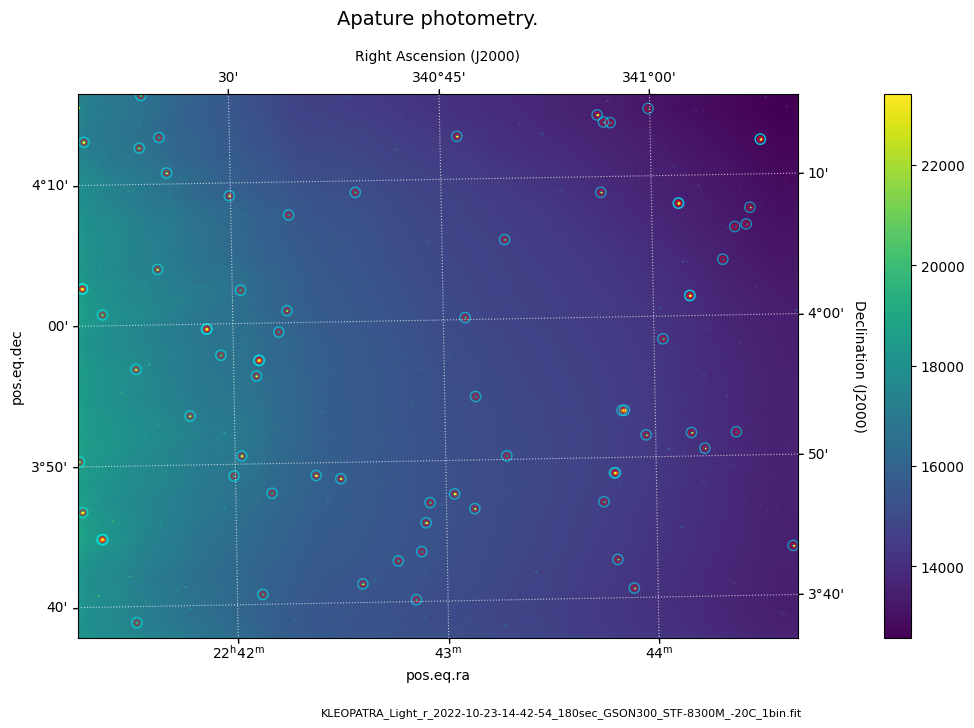

In [18]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.

pos = np.transpose((df_stars['xcentroid'], df_stars['ycentroid']))
aps1 = CAp(pos, r=12)
aps2 = CAp(pos, r=24)

fig, axs = plt.subplots(1, 1, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axs = plt.gca()
axs = plt.subplot(projection=ccd.wcs, label='overlay')
overlay = axs.get_coords_overlay('fk5')
#overlay = ax.get_coords_overlay('icrs')
overlay.grid(True, color='white', ls=':', alpha=0.7)
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

im = vis.norm_imshow(axs, ccd.data, zscale=True)
aps1.plot(color='r', lw=1, alpha=0.5)
aps2.plot(color='cyan', lw=1, alpha=0.5)

plt.title(f"Apature photometry.",
        fontsize = 14, pad=50)

plt.annotate(f"{str(fpath.name)}", fontsize=8, 
            xy=(1, 0), xytext=(3, -50), va='top', ha='right',
            xycoords='axes fraction', textcoords='offset points')

plt.colorbar(im, fraction=0.0455, pad=0.10)

plt.tight_layout()
plt.show();

In [ ]:
phot = apphot(ccd.data, [aps1, aps2])
phot["sky"] = (phot['aperture_sum_1'] - phot['aperture_sum_0']) / (aps2.area - aps1.area)
phot["flux"] = phot['aperture_sum_0'] - phot["sky"] * aps1.area
phot["mag"] = -2.5 * np.log10(phot["flux"])
for c in phot.colnames:
    phot[c].info.format = "%.2f" if c!="id" else "%d"

print("phot: ", phot)
phot.to_csv(f"{APhRESULTDIR / fpath.stem}_Apa_phot_stars.csv")
print(f"{APhRESULTDIR / fpath.stem}_Apa_phot_stars.csv is created...")


NameError: name 'ccd' is not defined

In [ ]:


# phot.pprint()
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

#axs[0].
axs[0].hist(phot["mag"], bins=10, histtype="step", lw=1, color="k")
axs[1].hist(phot["sky"], bins=50, histtype="step", lw=1, color="k")
axs[0].set(xlabel="mag_inst", ylabel="N", title="Histogram of instrumental mag")
axs[1].set(xlabel="sky", ylabel="N", title="Histogram of sky")
plt.tight_layout()
plt.show();

In [ ]:
ap_stats = apstats(ccd.data, aps1)
print("Median FWHM of circular 2D Gaussians: ", np.median(ap_stats.fwhm.value))
print("Median ellipticity: ", np.median(ap_stats.ellipticity))

Median FWHM of circular 2D Gaussians:  13.600743120845129
Median ellipticity:  0.014632409142406488


Starting photometry star 0:
Starting photometry star 1:
Starting photometry star 2:
Starting photometry star 3:
Starting photometry star 4:
Starting photometry star 5:
Starting photometry star 6:
Starting photometry star 7:
Starting photometry star 8:
Starting photometry star 9:
Starting photometry star 10:
Starting photometry star 11:
Starting photometry star 12:
Starting photometry star 13:
Starting photometry star 14:
Starting photometry star 15:
Starting photometry star 16:
Starting photometry star 17:
Starting photometry star 18:
phot_stars:     id      xcenter      ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  1732.820796  1313.272665  3.936537e+06       1984.070940  15106.851002   
0   1  1596.678360  1252.234867  3.976883e+06       1994.212429  15290.395879   
0   2  1551.513206  1092.230548  4.013012e+06       2003.250365  15337.747340   
0   3  1138.423382  1049.023792  4.138700e+06       2034.379477  15835.331189   
0   4  1633.021771  1844.580987  3.917482

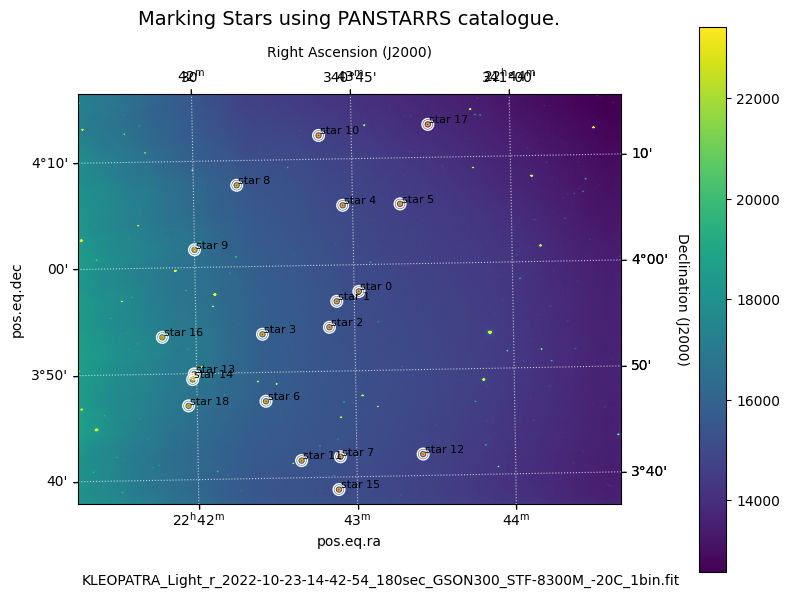

In [ ]:
# 각 별의 측광을 수행
_phot_stars = []
for idx, row in df_stars.iterrows():
	print("Starting photometry star {}:".format(idx))
	
	#별의 적경, 적위를 이미지 안에서의 픽셀 값으로 
	pos_star = SkyCoord(row["RAJ2000"], 
			row["DEJ2000"], 
			**SKYC_KW).to_pixel(ccd.wcs)
	ap = CAp([pos_star[0], 
		pos_star[1]], 
		r=R_AP)
	an = CAn([pos_star[0], 
		pos_star[1]], 
		r_in=R_IN, 
		r_out=R_OUT)
	_phot_star = ypu.apphot_annulus(ccd, ap, an, 
				error=yfu.errormap(ccd))
	_phot_star["{}mag".format(filt.upper())] = row["{}mag".format(filt.upper())]
	_phot_star["e_{}mag".format(filt.upper())] = row["e_{}mag".format(filt.upper())]
	_phot_star["grcolor"] = row["grcolor"]
	_phot_star["e_grcolor"] = row["e_grcolor"]
	_phot_star["id"] = idx
	_phot_star["objID"] = int(row["objID"])
	_phot_stars.append(_phot_star)
	
	axs.text(pos_star[0]+10, pos_star[1]+10, 
		f"star {idx}", fontsize=8)
	ap.plot(axs, color="orange")
	an.plot(axs, color="w")

plt.tight_layout()
plt.savefig("{}_stars.png".format(str(APhRESULTDIR / fpath.stem)))
#plt.show()
#%%
phot_stars = pd.concat(_phot_stars)
# phot_stars = phot_stars.loc[phot_stars["objID"] != 110823405221754720].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
print("phot_stars: ", phot_stars)
phot_stars.to_csv("{}_phot_stars.csv".format(str(APhRESULTDIR / fpath.stem)))

Starting RE-photometry star 0:
type(center): <class 'numpy.ndarray'>
center: [14.76042556 15.18149867]
center dx, dy: 1 0
center dx, dy: 1 0
center dx, dy: 1 0
ap Aperture: CircularAperture
positions: [49., 50.]
r: 12.0
type(ap) <class 'photutils.aperture.circle.CircularAperture'>
an Aperture: CircularAnnulus
positions: [49., 50.]
r_in: 24.0
r_out: 36.0
type(an) <class 'photutils.aperture.circle.CircularAnnulus'>
Sky estimation: 15116.500 +- 213.708
phot:  id xcenter ycenter ...   sky       source_sum          inst_mag     
      pix     pix   ...                                              
--- ------- ------- ... ------- ----------------- -------------------
  1    49.0    50.0 ... 15116.5 91860.51914012618 -6.7696409758885565
Starting RE-photometry star 1:
type(center): <class 'numpy.ndarray'>
center: [13.75834765 15.59834929]
center dx, dy: 2 0
center dx, dy: 2 0
center dx, dy: 2 0
ap Aperture: CircularAperture
positions: [48., 50.]
r: 12.0
type(ap) <class 'photutils.aperture.circ

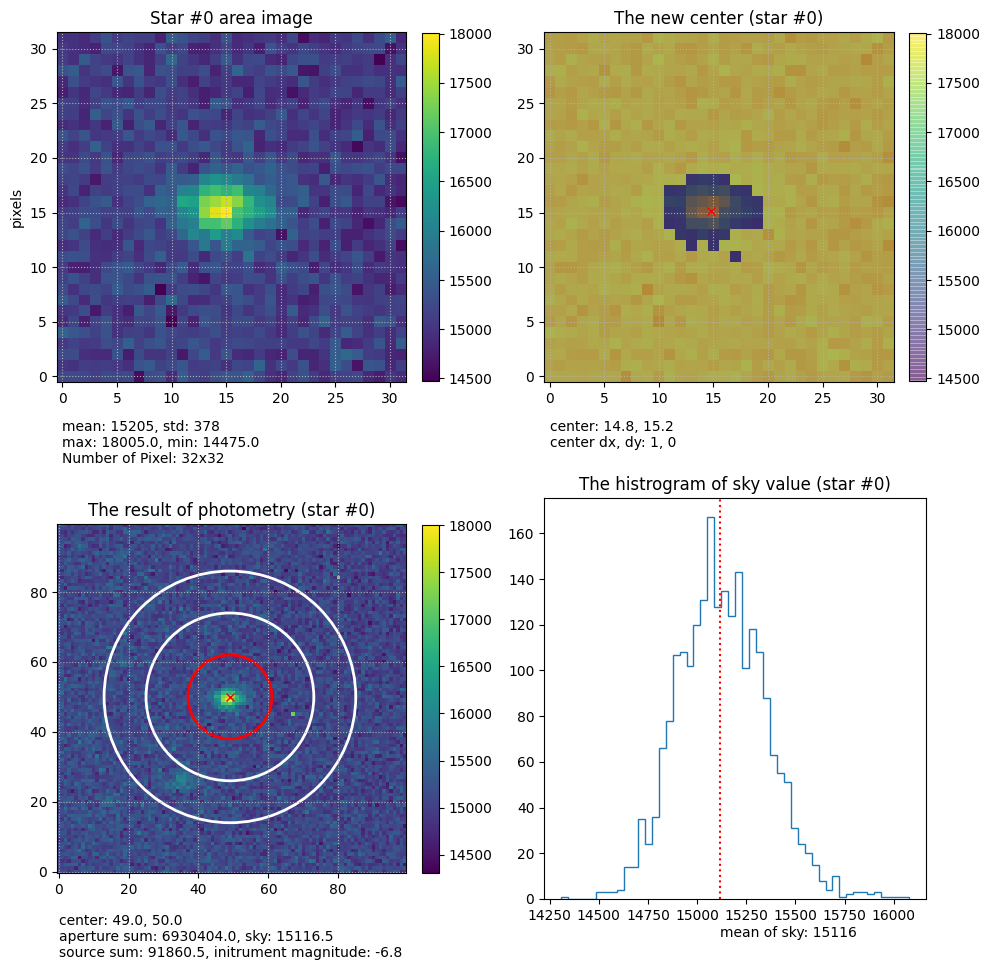

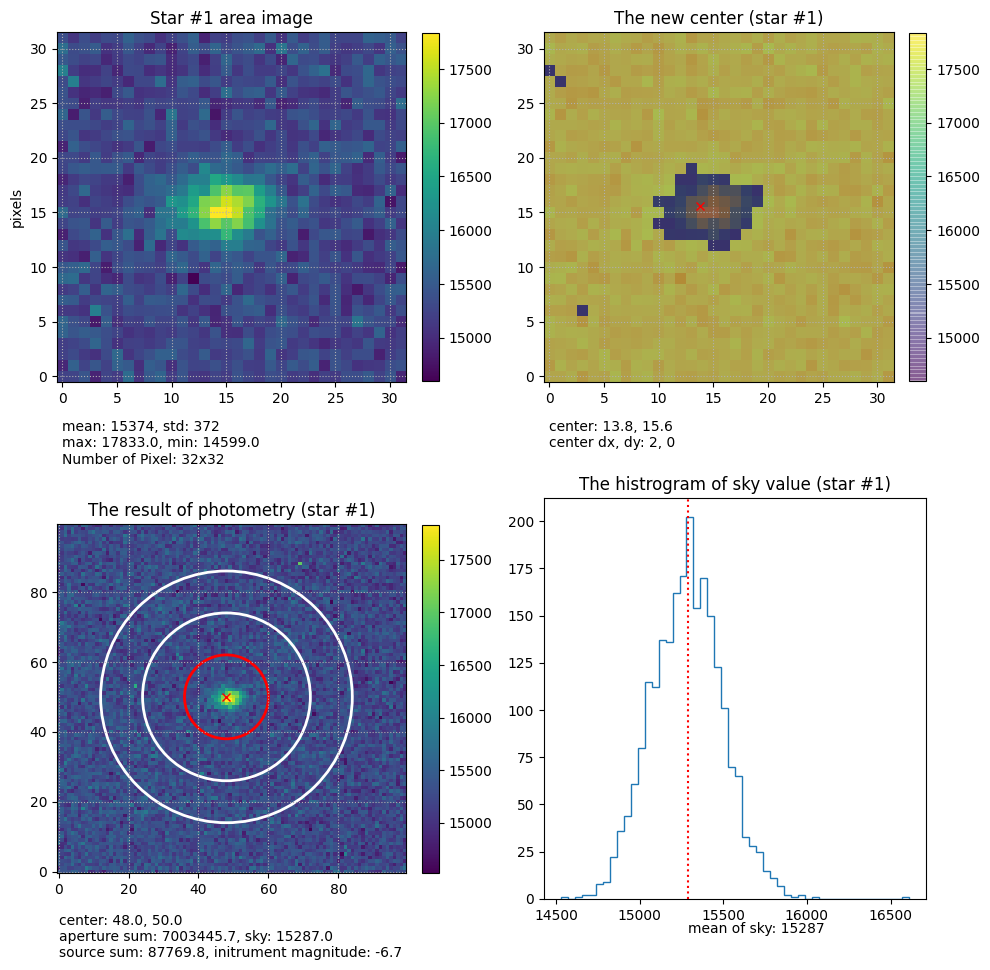

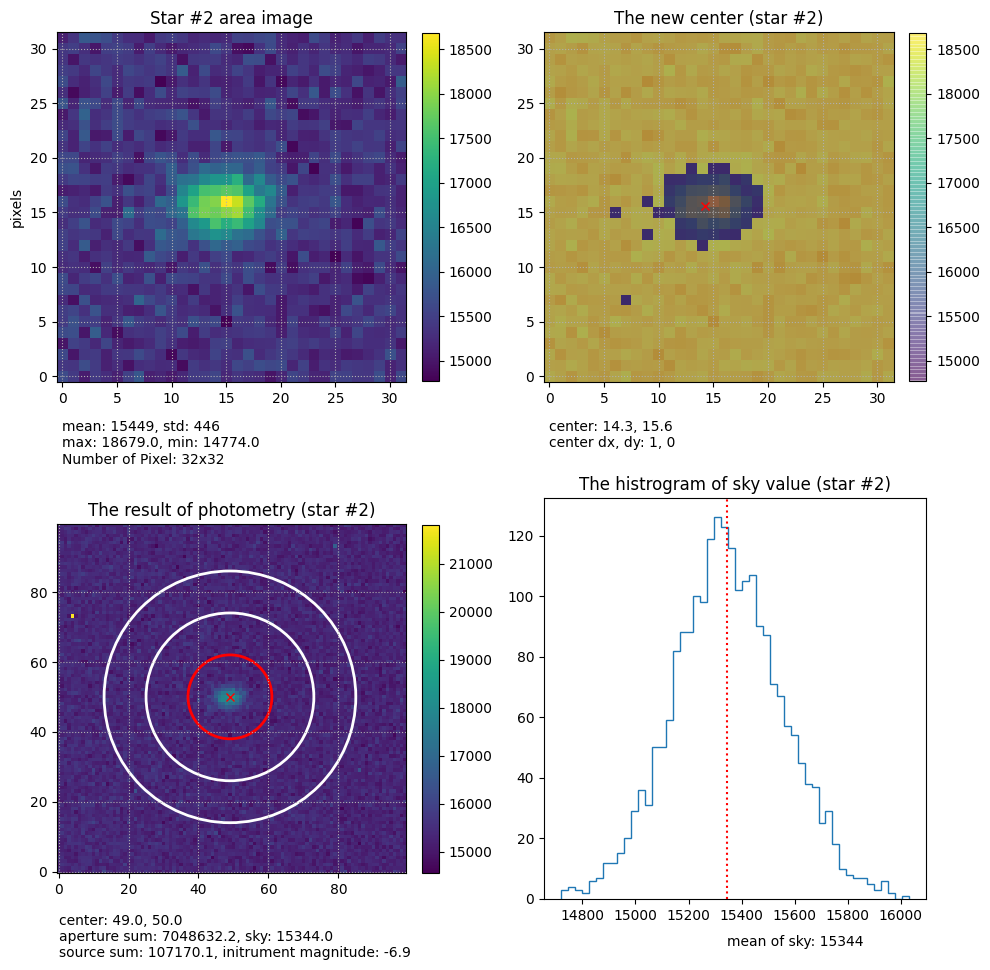

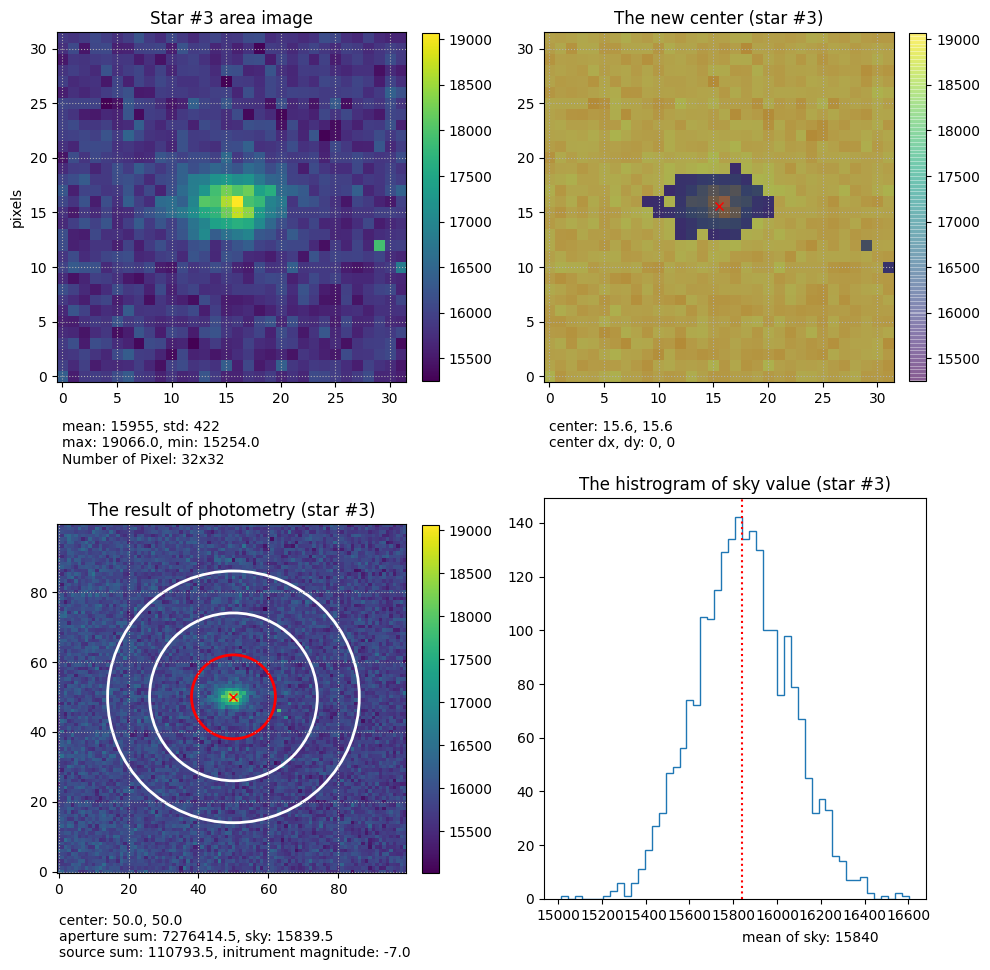

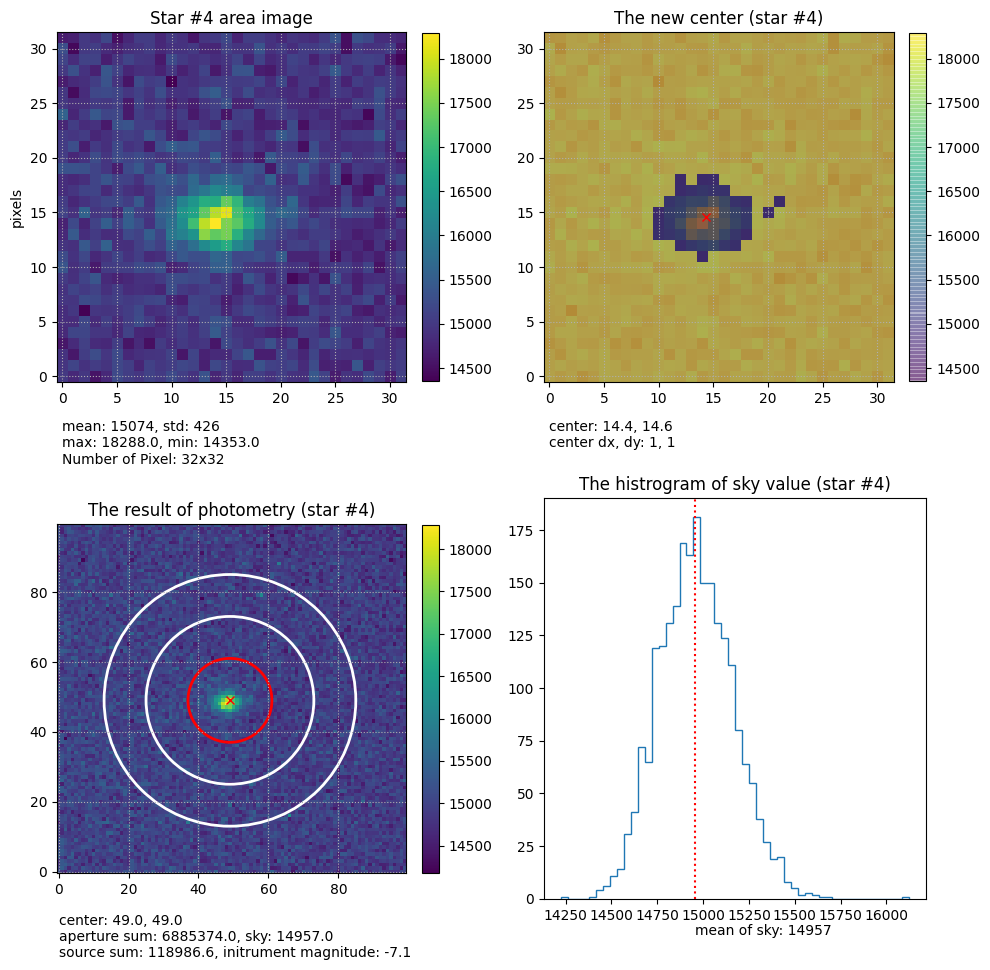

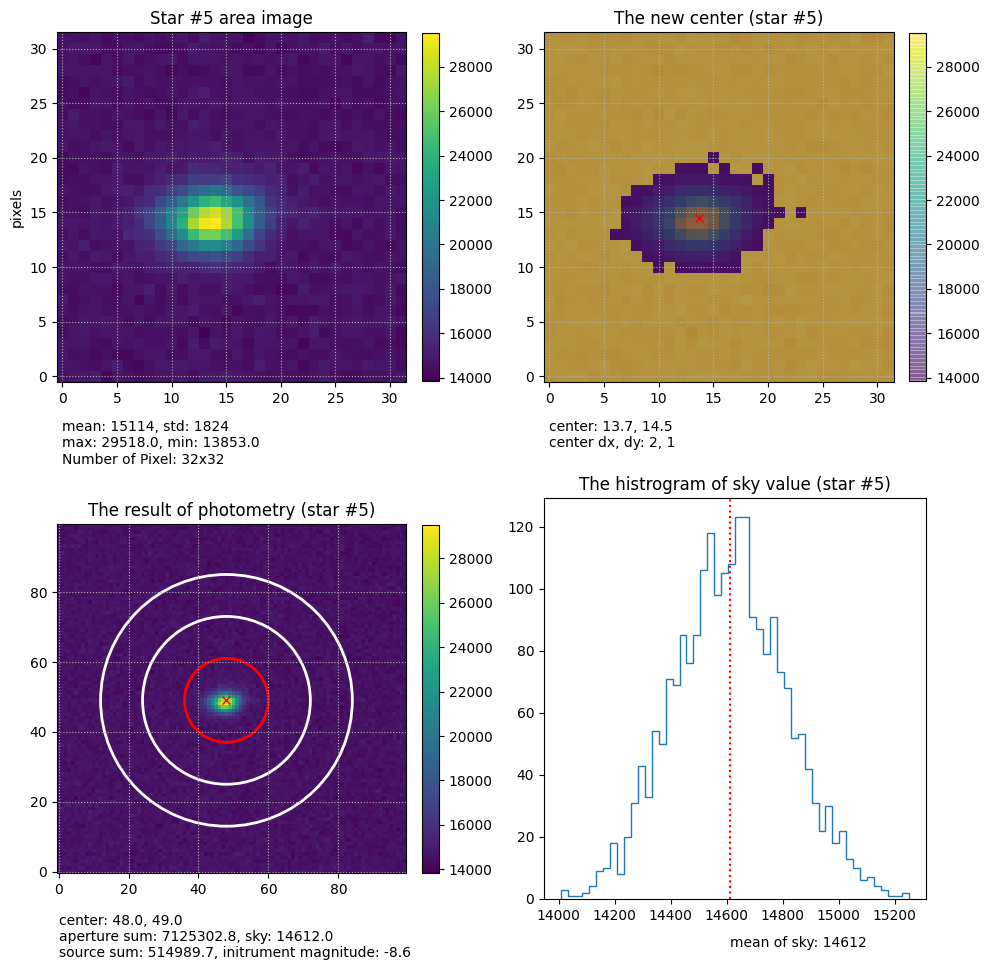

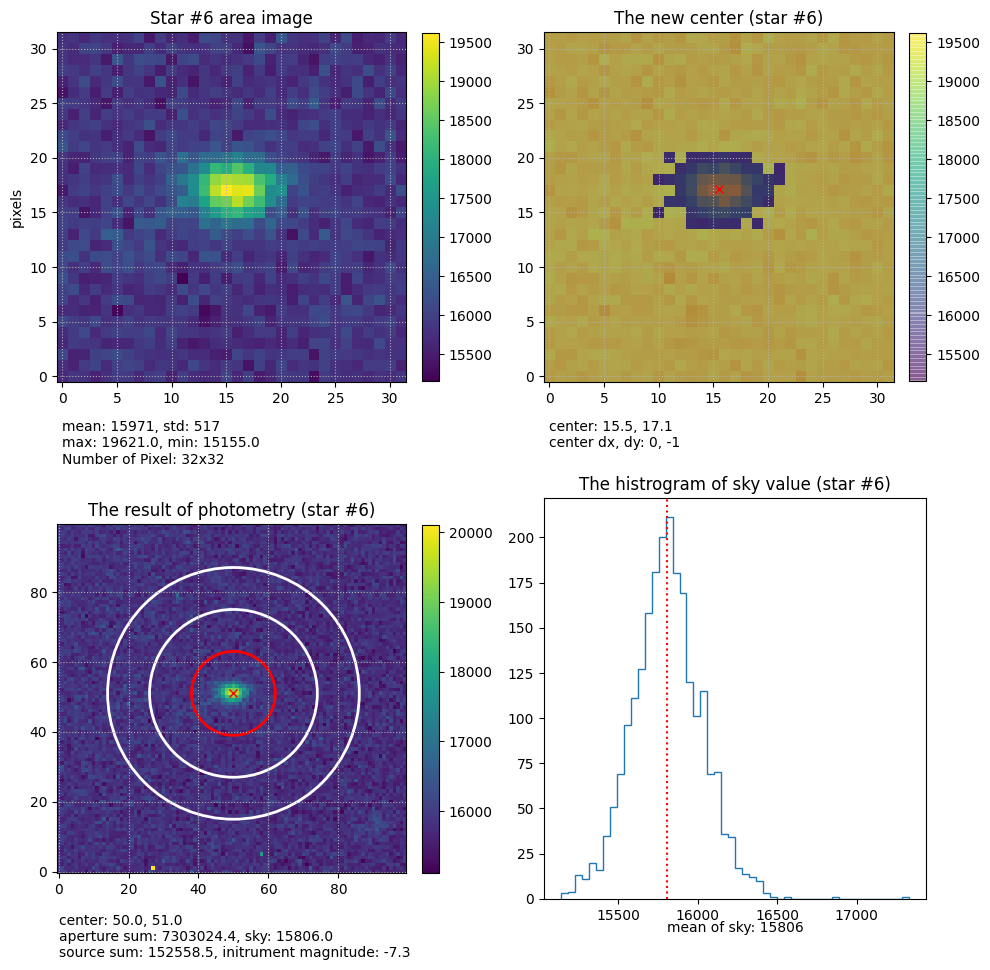

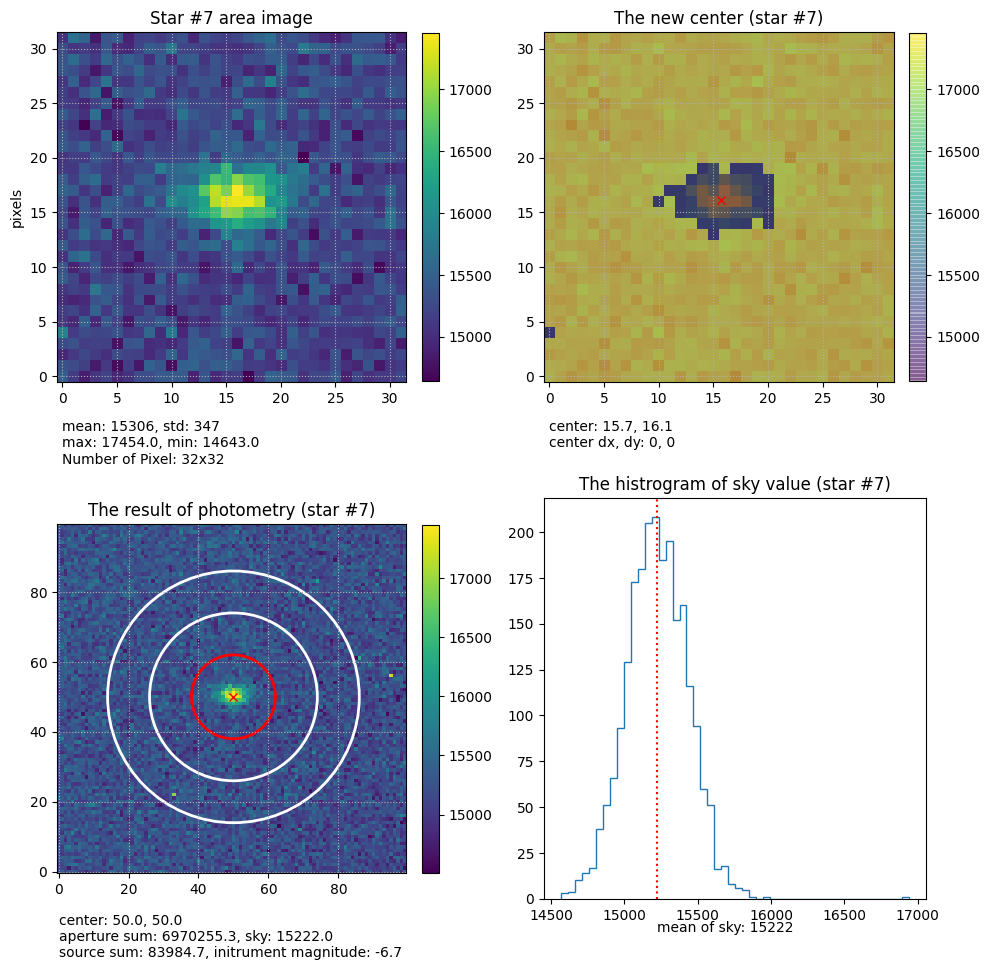

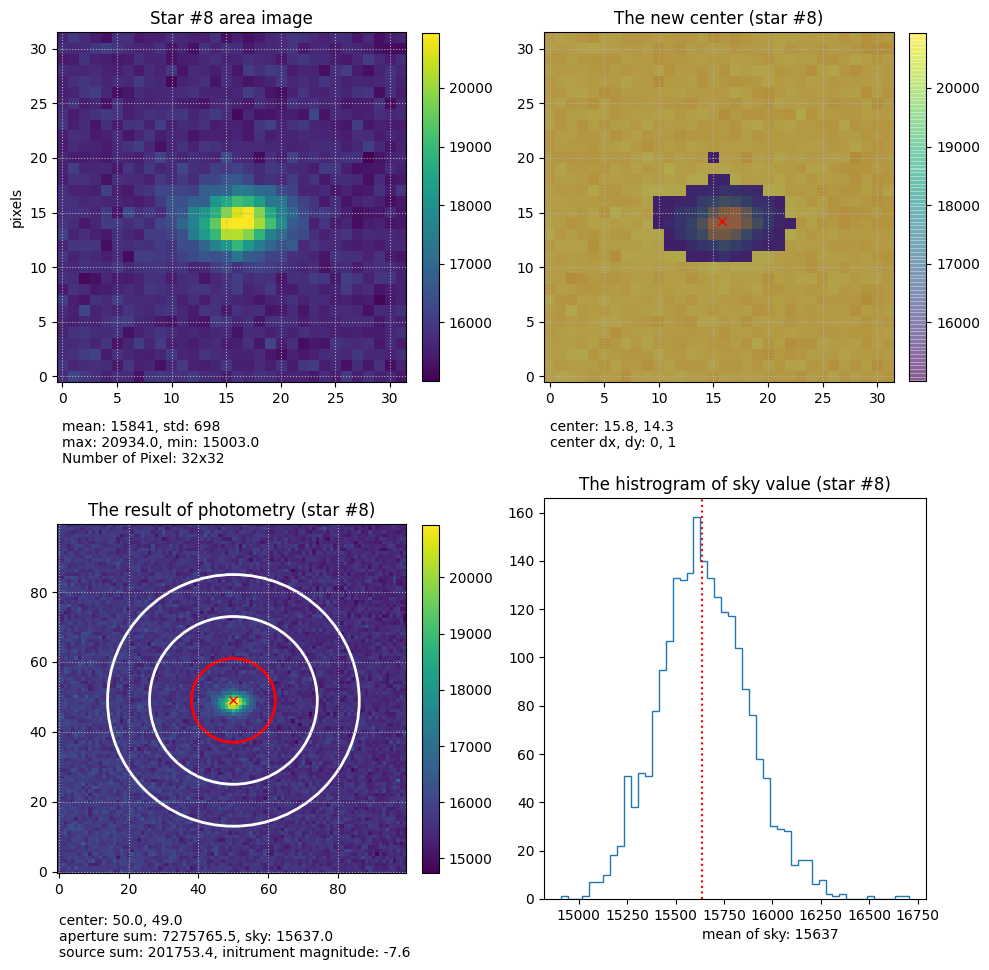

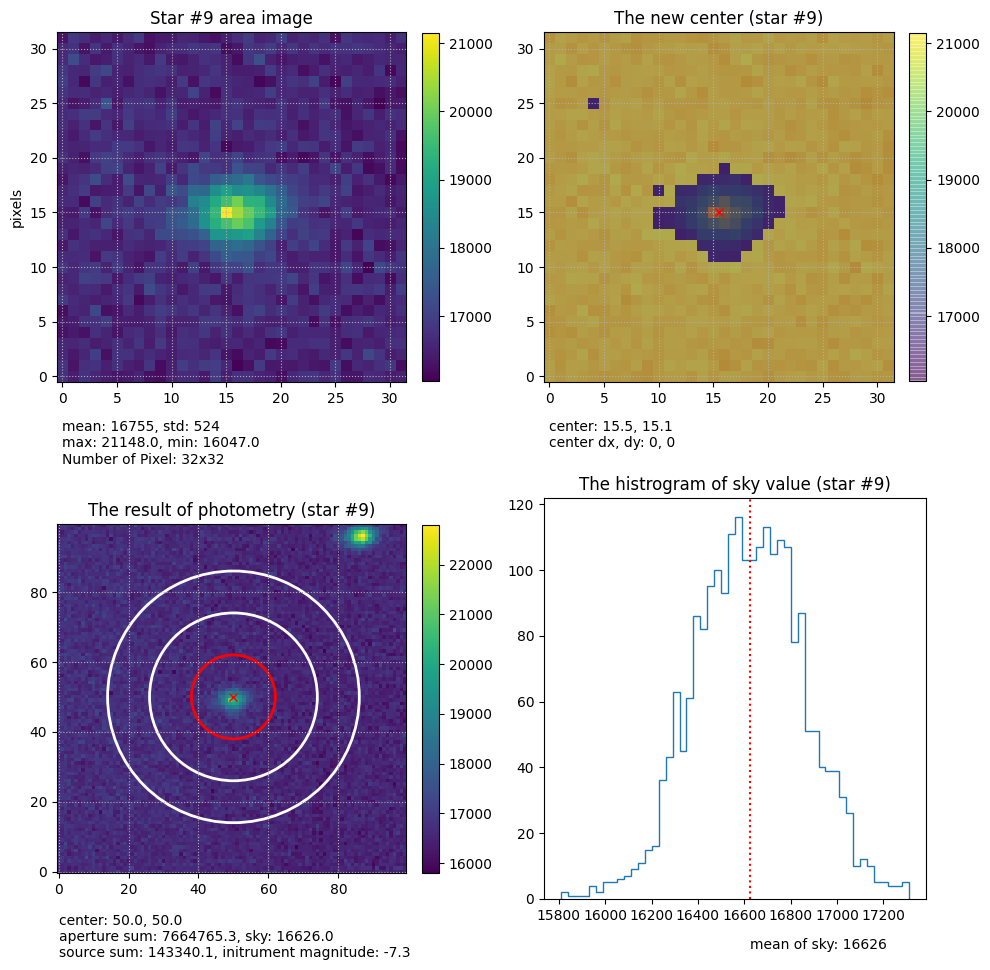

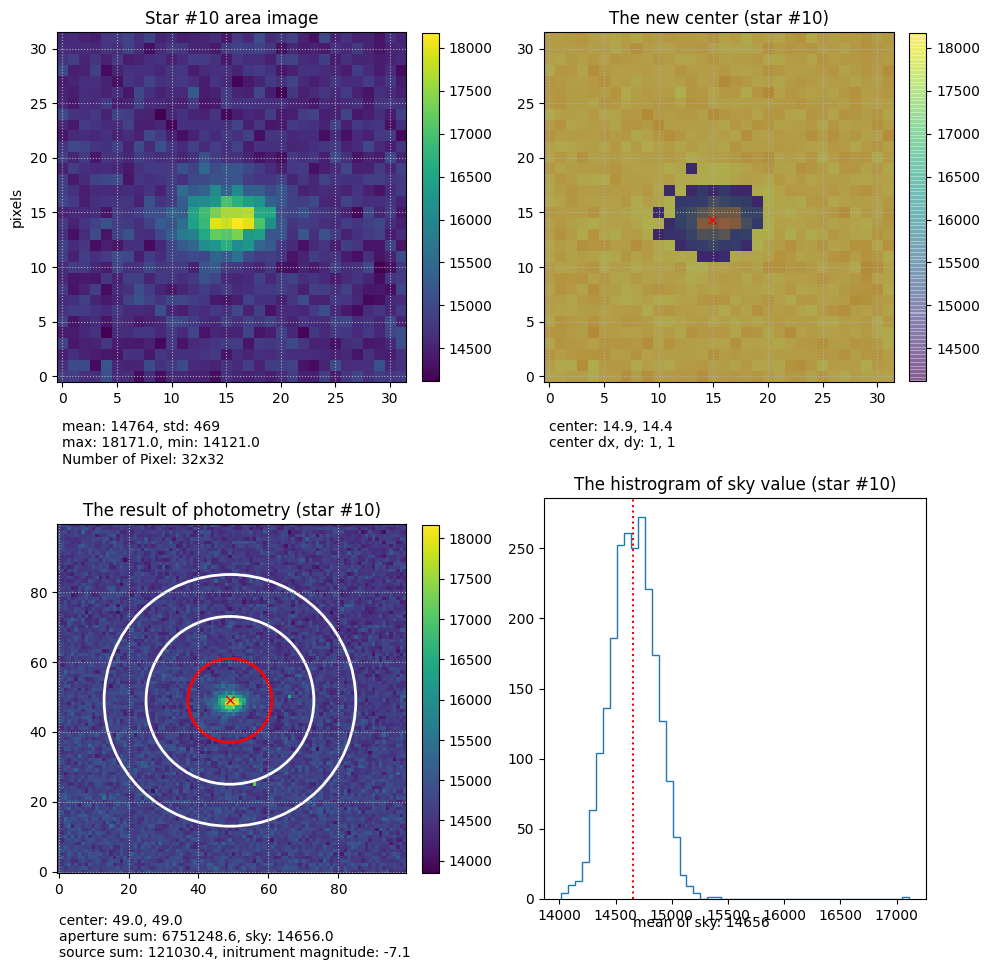

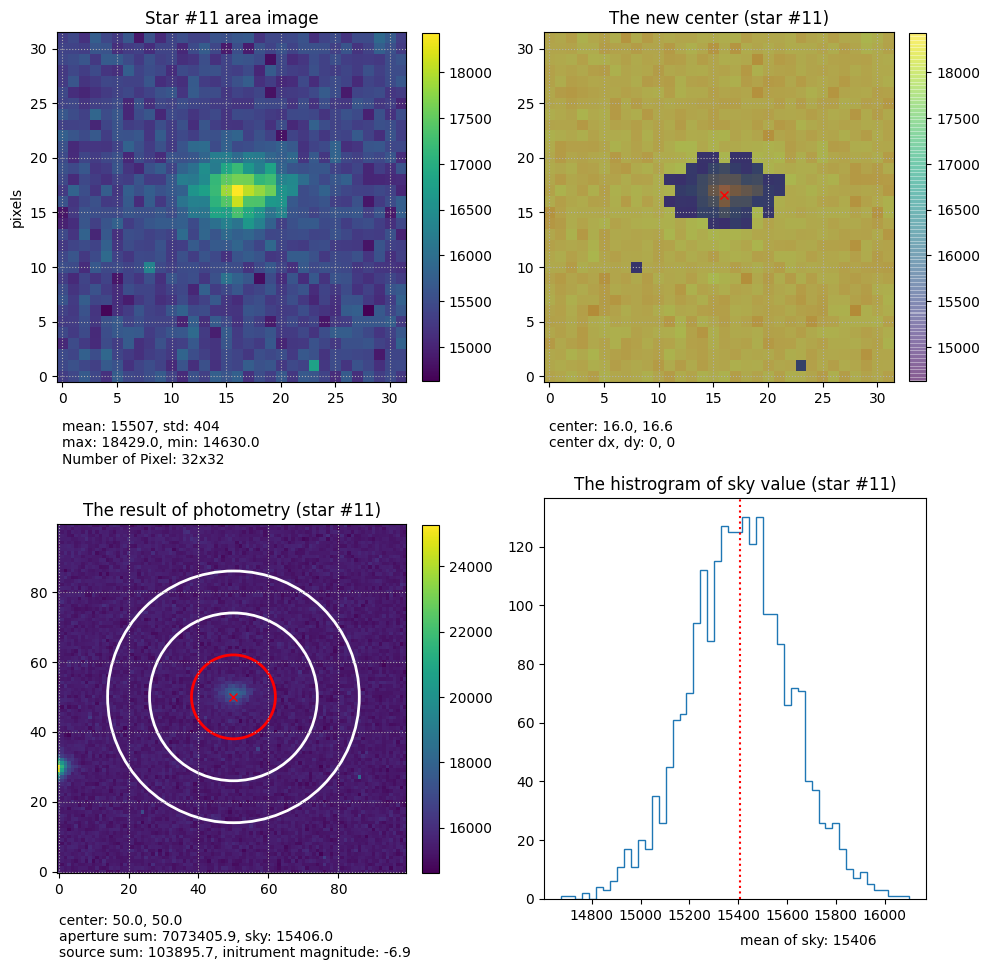

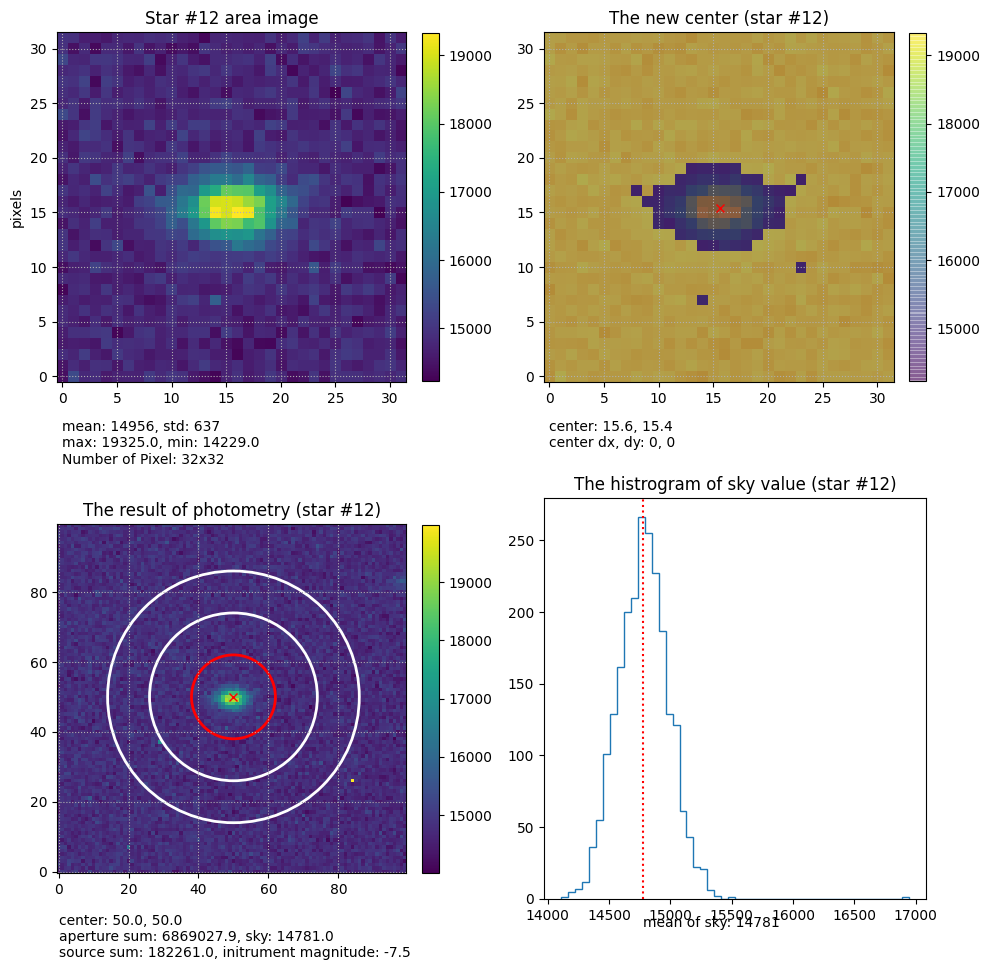

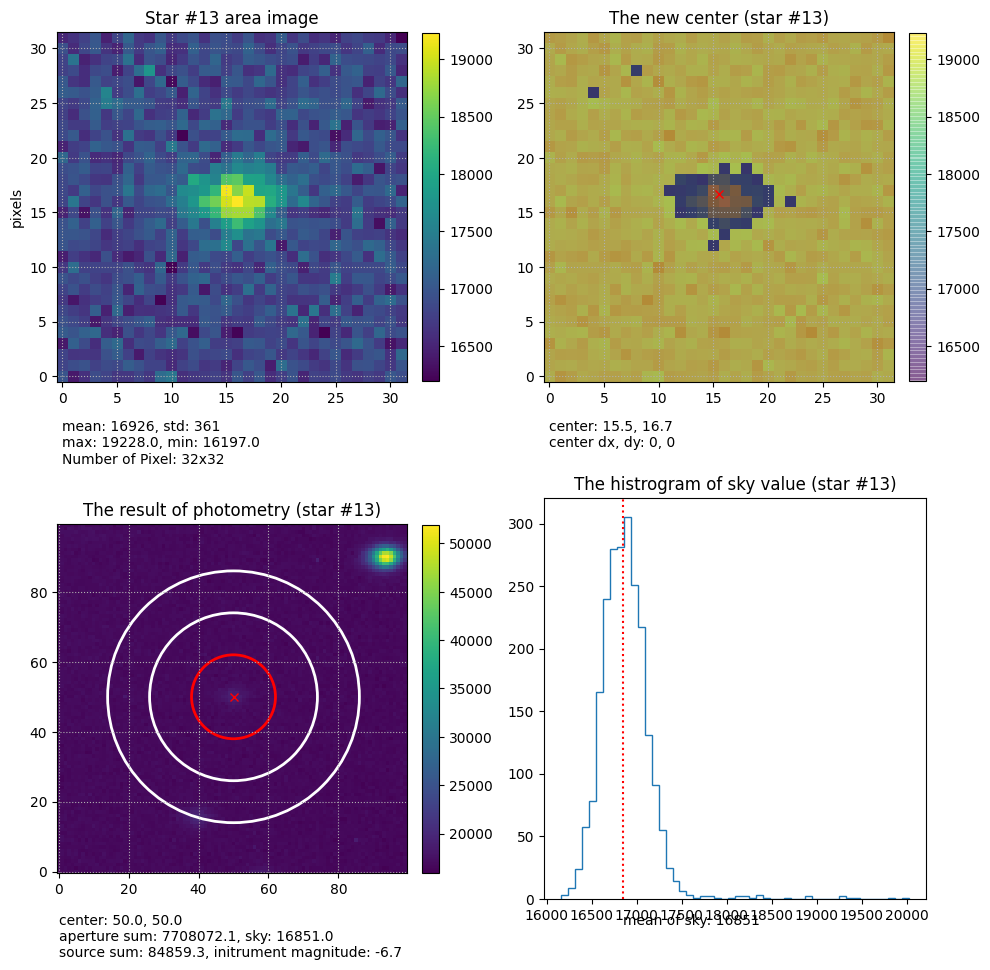

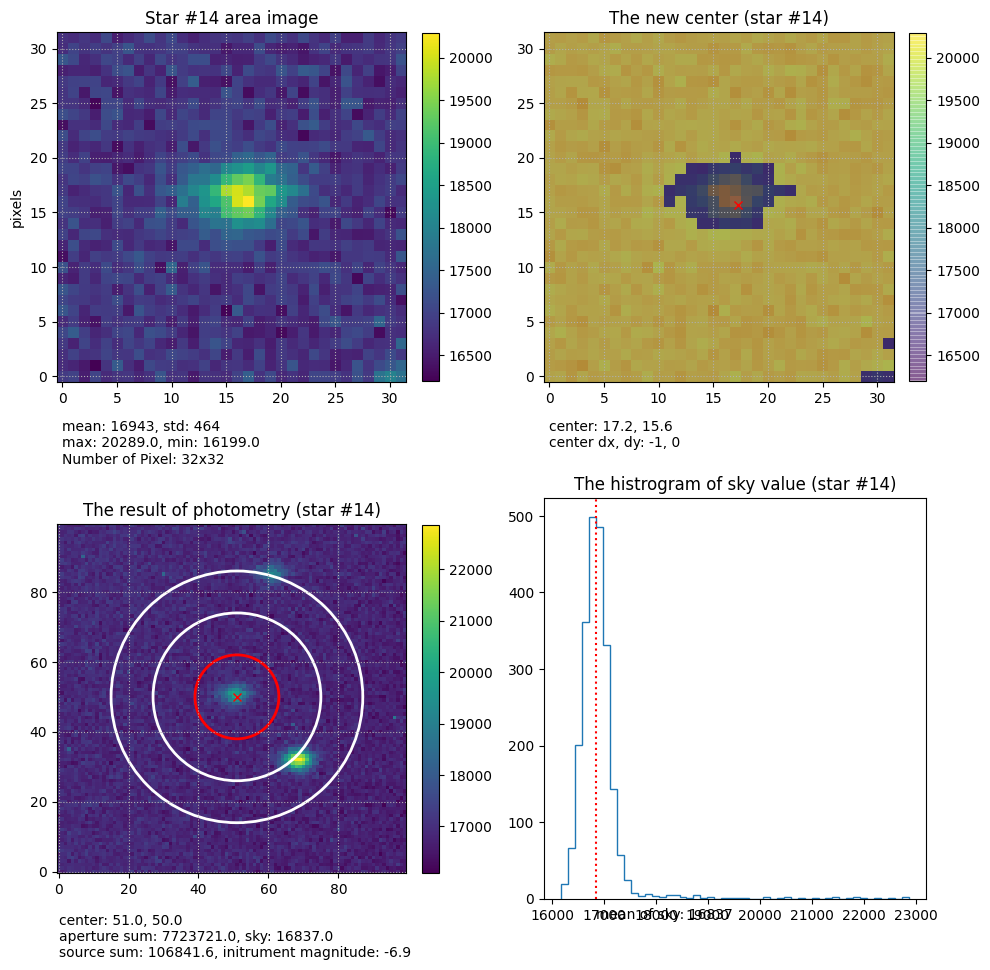

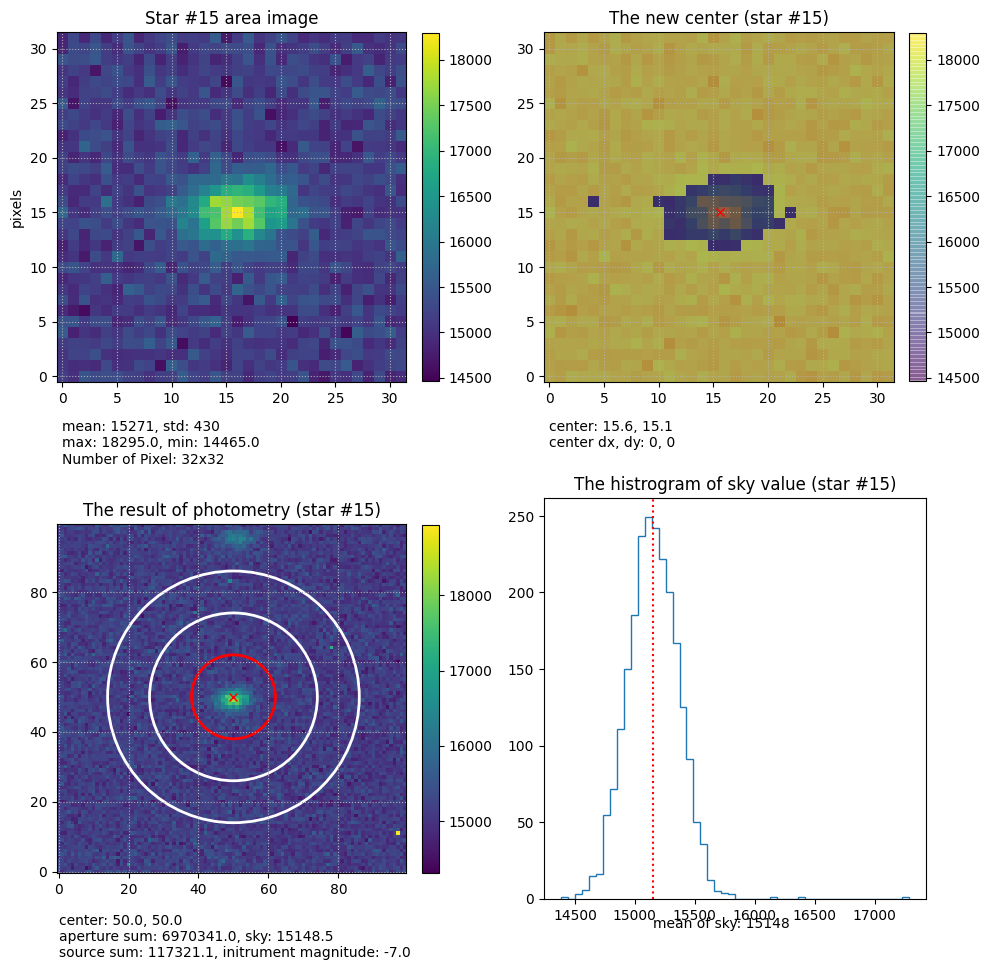

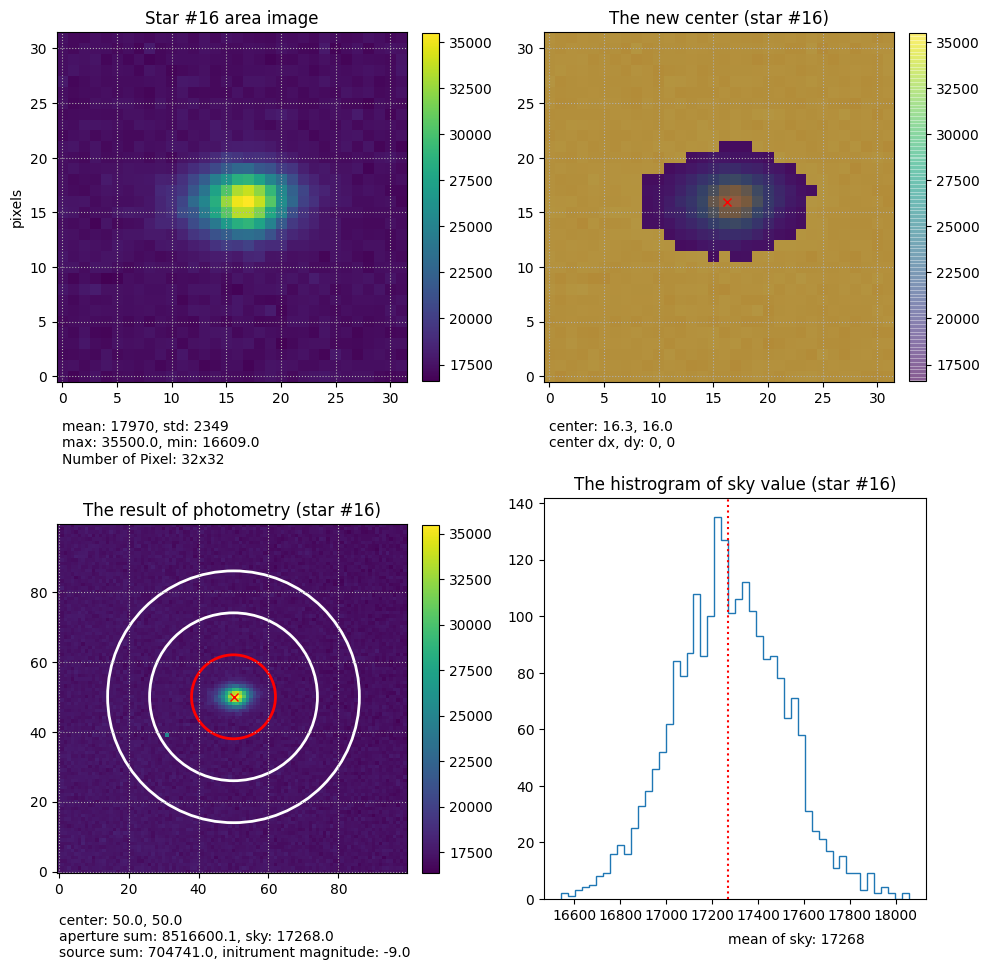

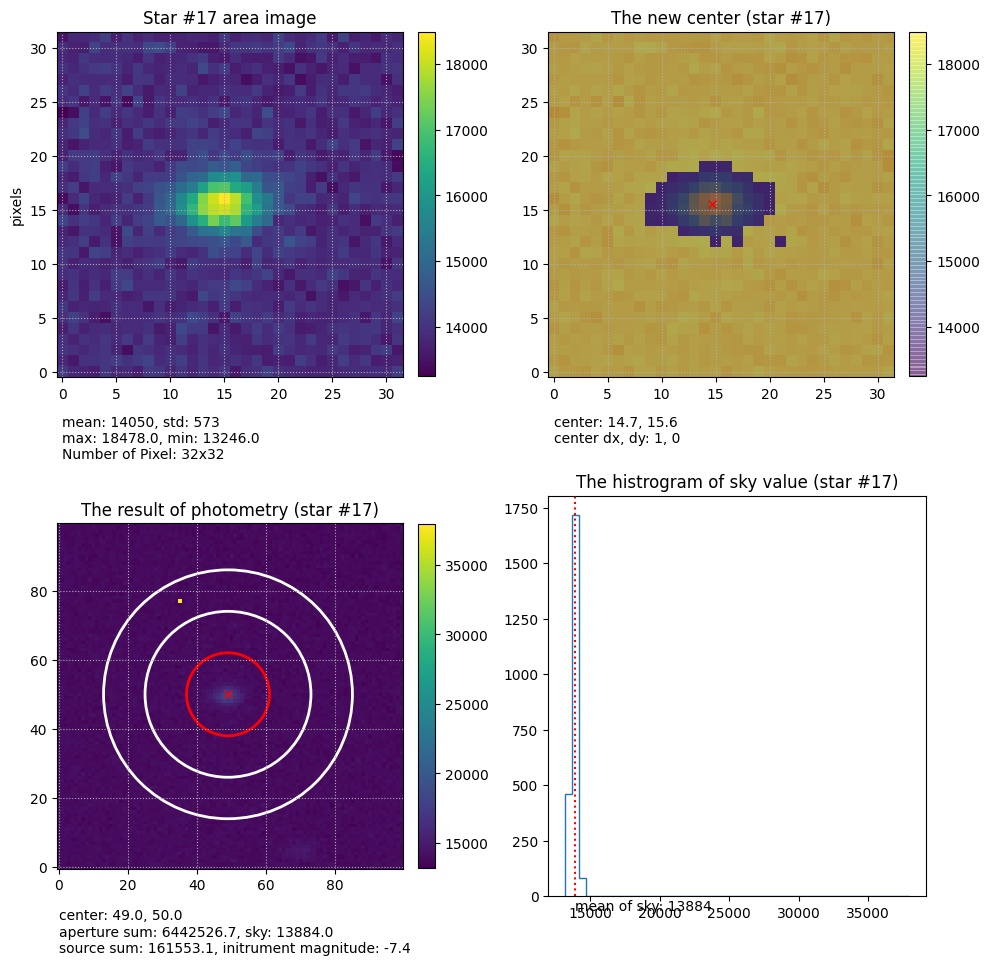

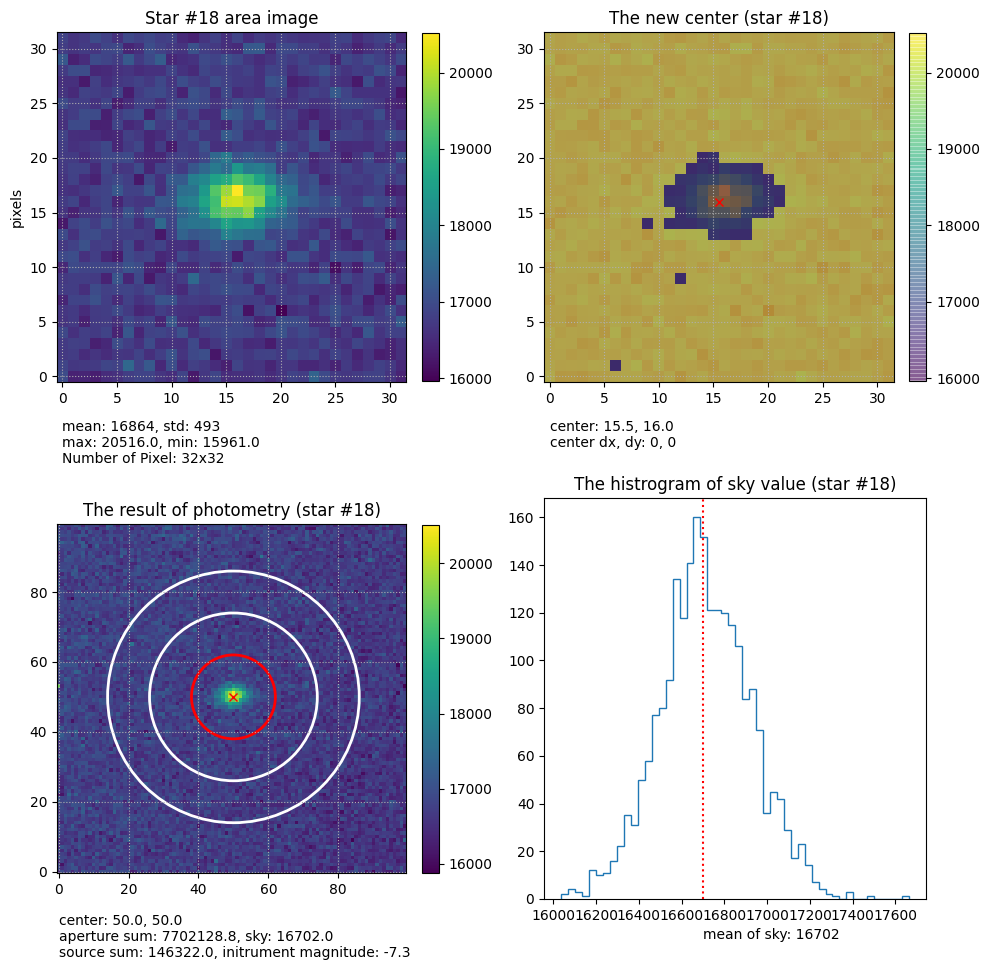

In [ ]:
#%%
# Centroid and Re-photometry
_phot_stars = []
for idx, row in df_stars.iterrows():
	print("Starting RE-photometry star {}:".format(idx))
	
	#1. 별의 적경, 적위를 이미지 안에서의 픽셀 값으로 
	pos_star = SkyCoord(row["RAJ2000"], 
			row["DEJ2000"], 
			**SKYC_KW).to_pixel(ccd.wcs)

	#2. Loading and Cut Data
	cutsizes = 32
	cut_hdu = Cutout2D(
		data = ccd, 
		position = ([pos_star[0], pos_star[1]]), 
		size=(cutsizes, cutsizes) #cut ccd
		)
	avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.
	thresh_3sig = med + 3 * std
	mask_3sig = (cut_hdu.data < thresh_3sig)
	center = centroid_com(
		data = cut_hdu.data, 
		mask = mask_3sig
		)
	
	centerdx = int(cutsizes/2-center[0])
	centerdy = int(cutsizes/2-center[1])

	print("type(center):", type(center))
	print("center:", center)
	print("center dx, dy:", centerdx, centerdy)
	print("center dx, dy:", centerdx, centerdy)
	print("center dx, dy:", centerdx, centerdy)
	
	#3. Loading and RE-Cut Data with New center
	bigcutsizes = 100
	bigcut_hdu = Cutout2D(
		data = ccd, 
		position = ([pos_star[0], pos_star[1]]), 
		size=(bigcutsizes, bigcutsizes) #cut ccd
		)
	avg, med, std = sigma_clipped_stats(bigcut_hdu.data)  # by default, 3-sigma 5-iteration.

	#4. Putting Aperture and Annulus
	bigcenter = [bigcutsizes/2 - centerdx, bigcutsizes/2 - centerdy]
	#bigcenter = [bigcutsizes/2 + centerdx, bigcutsizes/2 + centerdy]
	#fwhm = 4
	fwhm = FWHM_INIT
	r_ap = 2 * fwhm
	r_in = 4 * fwhm
	r_out = 6 * fwhm
	ap = CAp(positions = bigcenter, 
		r = r_ap)
	an = CAn(positions = bigcenter, 
		r_in = r_in, r_out = r_out)
	print("ap", ap)
	print("type(ap)", type(ap))
	print("an", an)
	print("type(an)", type(an))

	# 5. Estimating Sky
	sky_mask = an.to_mask(method = 'center')

	try:  # prior to photutils 0.7
		sky_vals = sky_mask[0].multiply(bigcut_hdu.data)
	except TypeError:
		sky_vals = sky_mask.multiply(bigcut_hdu.data)

	sky_vals = sky_vals[sky_vals > 0]
	avg, med, std = sigma_clipped_stats(
				sky_vals, 
				sigma=3, 
				maxiters=10, 
				std_ddof=1
				)

	if med - avg < 0.3 * std:
		msky = med
	else:
		msky = 2.5 * med - 1.5 * avg

	print(f"Sky estimation: {msky:.3f} +- {std:.3f}")

	phot = apphot(
		data = bigcut_hdu.data, 
		apertures = ap
		)
	phot["sky"] = msky
	
	try:  # prior to photutils 0.7
		phot["source_sum"] = phot["aperture_sum"] - ap.area() * phot["sky"]
	
	except TypeError:
		phot["source_sum"] = phot["aperture_sum"] - ap.area * phot["sky"]
	
	phot["inst_mag"] = -2.5 * np.log10(phot["source_sum"] / ccd.header["EXPTIME"])
	print("phot:", phot)

	#%%
	fig = plt.figure(figsize=(10, 10))
	ax1 = plt.subplot(2, 2, 1)
	im1 = ax1.imshow(cut_hdu.data, 
		origin='lower'
		)
	ax1.set_ylabel('pixels')
	ax1.grid(ls=':')
	ax1.set_title(f'Star #{idx} area image')
	ax1.text( 0, -4, 
		f"mean: {np.mean(cut_hdu.data):.0f}, std: {np.std(cut_hdu.data):.0f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
		va = 'top')
	plt.colorbar(im1, 
		ax=ax1,
		fraction=0.0455, pad=0.04)

	ax2 = plt.subplot(2, 2, 2)
	ax2.grid(ls=':')
	ax2.set_title(f'The new center (star #{idx})')
	im21 = ax2.imshow(mask_3sig.astype(int), 
		origin="lower")
	im22 = ax2.imshow(cut_hdu.data, 
			alpha=0.4, 
			origin="lower")
	ax2.plot(*center, 'rx')
	ax2.text(0, -4, 
		f"center: {center[0]:.01f}, {center[1]:.1f}\ncenter dx, dy: {centerdx}, {centerdy}",
		va = 'top'
		)
	# plt.colorbar(im21, 
	# 	ax=ax2,
	# 	fraction=0.0455, pad=0.04)
	plt.colorbar(im22, 
		ax=ax2,
		alpha=0.4, 
		fraction=0.0455, pad=0.04)
		
	ax3 = plt.subplot(2, 2, 3)
	ax3.grid(ls=':')
	ax3.set_title(f'The result of photometry (star #{idx})')
	im3 = ax3.imshow(bigcut_hdu.data,
			origin='lower' )
	ap.plot(ax3, color='r', lw=2)
	an.plot(ax3, color='w', lw=2)
	ax3.plot(*bigcenter, 'rx')
	ax3.text(0, -12, 
		f"center: {bigcenter[0]:.01f}, {bigcenter[1]:.1f}\naperture sum: {float(phot['aperture_sum']):.01f}, sky: {float(phot['sky']):.01f}\nsource sum: {float(phot['source_sum']):.01f}, initrument magnitude: {float(phot['inst_mag']):.01f}",
		va = 'top'
		)
	plt.colorbar(im3, 
		ax=ax3,
		fraction=0.0455, pad=0.04)

	ax4 = plt.subplot(2, 2, 4)
	ax4.set_title(f'The histrogram of sky value (star #{idx})')
	ax4.hist(sky_vals, 50, histtype='step')
	ax4.axvline(msky, ls=':', color='r')

	ax4.text(msky, -12, 
		f'mean of sky: {msky:.0f}',
		va = 'top'
		)

	plt.tight_layout()
	plt.savefig("{}_star_{:02d}.png".format(str(APhRESULTDIR / fpath.stem), idx))

## guide test1